# Modeling with TensorFlow


In [1]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    tf.test.gpu_device_name()
    # need to use gpu runtime accelerator!
    !pip install imageai
    from google.colab import drive
    drive.mount('/content/gdrive')

In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
import cv2 as cv
from imageai.Detection import ObjectDetection
import os
import random, math

Using TensorFlow backend.


# Create generator


In [3]:
!pwd

/c/Users/User/Documents/GitHub/sidewalks_deep-learning


In [4]:
if IN_COLAB:
    os.chdir(f'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/images/')
else:
    os.chdir(f'./images/')
!pwd

/c/Users/User/Documents/GitHub/sidewalks_deep-learning/images


In [29]:
#move images into train, test, validate folders with subfolders for classes
test_ratio = .15
SPLIT_DATA = False # switch if need to divide out data
if SPLIT_DATA:
    for label in ['sidewalk', 'no_sidewalk']:
        %cd ./$label
        listing = os.popen('ls').read().strip().split(sep='\n')
        random.shuffle(listing) #inplace
        im_count = len(listing)
        test_size=val_size = math.ceil(test_ratio*im_count)
        train_size = im_count - test_size
        subfolders = ['train', 'test'] #train will be used for vdation too
        for subfolder in subfolders:
            os.makedirs(os.path.join(
                os.path.dirname(os.getcwd()), subfolder, label))
        for item in range(0, train_size):
            moved = listing.pop()
            !mv $moved ../train/$label/$moved
        for item in range(0, test_size):
            moved = listing.pop()
            !mv $moved ../test/$label/$moved
        %cd ..
        !rmdir ./$label

[WinError 2] The system cannot find the file specified: './sidewalk'
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\sidewalk
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images
C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images\no_sidewalk


Parameter format not correct - "sidewalk".


C:\Users\User\Documents\GitHub\sidewalks_deep-learning\images


Invalid switch - "no_sidewalk".


### Parameters for data loading

In [ ]:
idg_params={'rescale': 1./255}
augmentation_params = {'rotation_range': 15,
                        'zoom_range': 0.15,
                         'width_shift_range': 0.2,
                         'height_shift_range': 0.2,
                         'shear_range': 0.15,
                         'fill_mode': 'nearest',
                         'horizontal_flip': True}
datagen_params = {'batch_size': 8,
                  'target_size': (480,480),
                  'color_mode': 'rgb', 
                  'class_mode': 'binary'}

In [93]:
train_vdate_datagen = ImageDataGenerator(
    **idg_params,
    validation_split=0.2)
train_augmented_datagen = ImageDataGenerator(
    **idg_params,
    **augmentation_params,
    validation_split=0.2)
test_datagen = ImageDataGenerator(**idg_params)

In [94]:
# Flow training images in batches of 128 using train_datagen generator
vdate_generator = train_vdate_datagen.flow_from_directory(
        r'./train/',
        subset='validation',
        **datagen_params)
train_generator = train_vdate_datagen.flow_from_directory(
        r'./train/',
        subset='training',
        **datagen_params)
test_generator = test_datagen.flow_from_directory(
        r'./test/',
        **datagen_params)

Found 417 images belonging to 2 classes.
Found 1670 images belonging to 2 classes.
Found 448 images belonging to 2 classes.


### Parameters for Modeling

In [81]:
batch_size = 128
n_epochs = 30

In [82]:
learning_rate = 0.000001
loss = 'binary_crossentropy'

In [83]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning\\images'

In [84]:
imagecount = {}
sidewalk_image_count = ! cd ./train/sidewalk/ && ls | wc -l
no_sidewalk_image_count = ! cd ./train/no_sidewalk/ && ls | wc -l
imagecount['sidewalk'] = int(sidewalk_image_count.nlstr)
imagecount['no_sidewalk'] = int(no_sidewalk_image_count.nlstr)
imagecount['total'] = imagecount['sidewalk'] + imagecount['no_sidewalk']

imagecount

{'sidewalk': 1430, 'no_sidewalk': 657, 'total': 2087}

In [85]:
#adjust weights to equivalent between classes
class_weight = {}
class_weight['sidewalk'] = (
    .5 / imagecount['sidewalk']) * imagecount['total']
class_weight['no_sidewalk'] = (
    .5 / imagecount['no_sidewalk']) * imagecount['total']
class_weight

{'sidewalk': 0.7297202797202798, 'no_sidewalk': 1.5882800608828005}

In [86]:
class_id = train_vdate_generator.class_indices

In [87]:
class_weight[class_id['sidewalk']] = class_weight.pop('sidewalk')
class_weight[class_id['no_sidewalk']] = class_weight.pop('no_sidewalk')
class_weight

{1: 0.7297202797202798, 0: 1.5882800608828005}

In [88]:
#generator based caluculations
input_shape = train_vdate_generator.next()[0].shape[1:]
total_train_vdate_samples = train_vdate_generator.n
total_vdate_samples = vdate_generator.n
input_shape

(480, 480, 3)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs=n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, ax = plt.subplots()
    ax.plot(n_epochs_range, history.history["loss"], label="train_loss")
    ax.plot(n_epochs_range, history.history["accuracy"], label="train_acc")
    if plot_validation:
        ax.plot(n_epochs_range, history.history["val_loss"], label="val_loss")
        ax.plot(n_epochs_range, history.history["val_acc"], label="val_acc")

    ax.set_title("Training Loss and Accuracy on Dataset")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss/Accuracy")
    ax.legend()
    plt.plot();
    
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'matthews_correlation']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

### Convolutional Model

In [95]:
conv_model = tf.keras.models.Sequential()
conv_model.add(Conv2D(64, kernel_size=(5,5),
                 activation='relu',
                 input_shape=input_shape))
conv_model.add(Conv2D(32, (4, 4), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.25))
conv_model.add(Conv2D(32, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Dropout(0.25))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dropout(0.25))
conv_model.add(Dense(32, activation='relu'))
conv_model.add(Dropout(0.25))
conv_model.add(Dense(1, activation='sigmoid'))

conv_model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(),
                      'matthews_correlation'])
conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 476, 476, 64)      4864      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 473, 473, 32)      32800     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 236, 236, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 236, 236, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 234, 234, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 117, 117, 32)      0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 117, 117, 32)     

In [ ]:
conv_history = conv_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        validation_data=vdate_generator,
        validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False,
        class_weight=class_weight)
history_plotter(history=conv_history, plot_validation=True)

Epoch 1/30
16/16 [==============================] - 360s 22s/step - loss: 0.6263 - accuracy: 0.6641 - auc_2: 0.5740 - val_loss: 0.6574 - val_accuracy: 0.6667 - val_auc_2: 0.3711
Epoch 2/30
 9/16 [===============>..............] - ETA: 2:28 - loss: 0.7499 - accuracy: 0.5833 - auc_2: 0.4034

KeyError: 'auc'

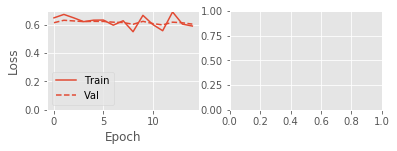

In [36]:
plot_metrics(conv_history)

# Object Detection via Transfer Learning


In [79]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet')
pretrained_mobilenet.trainable = False

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [80]:
global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

mnet_model = tf.keras.Sequential([
  pretrained_mobilenet,
  global_pooling_layer,
  tf.keras.layers.Dense(64),
  prediction_layer])

mnet_model.compile(optimizer=RMSprop(lr=learning_rate),
              loss=loss,
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(),
                       'matthews_correlation'])
mnet_model.summary()

ValueError: Unknown metric function:matthews_correlation

In [13]:
mnet_history = mnet_model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_train_samples/batch_size),  
        epochs=n_epochs,
        verbose=1,
        #validation_data=vdate_datagen,
        #validation_steps=int(total_vdate_samples/batch_size),
        use_multiprocessing=False)

Epoch 1/15
16/16 [==============================] - 59s 4s/step - loss: 4.5950 - accuracy: 0.4141
Epoch 2/15
16/16 [==============================] - 61s 4s/step - loss: 3.3165 - accuracy: 0.5234
Epoch 3/15
16/16 [==============================] - 67s 4s/step - loss: 2.7588 - accuracy: 0.6094
Epoch 4/15
16/16 [==============================] - 60s 4s/step - loss: 2.5841 - accuracy: 0.5469
Epoch 5/15
16/16 [==============================] - 60s 4s/step - loss: 2.5826 - accuracy: 0.6094
Epoch 6/15
16/16 [==============================] - 68s 4s/step - loss: 1.9813 - accuracy: 0.6172
Epoch 7/15
16/16 [==============================] - 60s 4s/step - loss: 2.3671 - accuracy: 0.5859
Epoch 8/15
16/16 [==============================] - 64s 4s/step - loss: 1.8892 - accuracy: 0.6562
Epoch 9/15
16/16 [==============================] - 64s 4s/step - loss: 2.3098 - accuracy: 0.6172
Epoch 10/15
16/16 [==============================] - 66s 4s/step - loss: 2.1028 - accuracy: 0.6406
Epoch 11/15
16/16 [

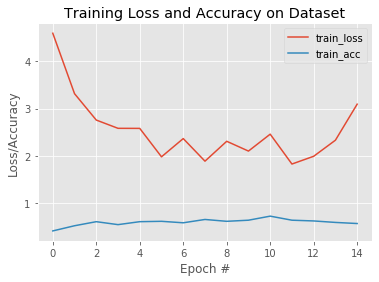

In [19]:
history_plotter(mnet_history, plot_validation=False)

# Object Segmentation
This will use a pretrained model as the basis for a nn that identifies the part of an image file that contains the sidewalk object.

In [ ]:
model_path = "./models/yolo-tiny.h5"
input_path = "./input/test45.jpg"
output_path = "./output/newimage.jpg"

### tinyYOLOv3

In [ ]:
detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()

#returns dictionary with name and probabilities of objects detected
detection = detector.detectObjectsFromImage(input_image=input_path, output_image_path=output_path)

### ResNet